<a href="https://colab.research.google.com/github/JoGyeongDeok/Project/blob/main/Dacon/2021_12_31_AI_Competition_to_Predict_Parking_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "AI Competition to Predict Parking Demand"

## 1.Library & Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')      

In [ ]:
# !mkdir "/content/drive/MyDrive/DACON/Data/AI Competition to Predict Parking Demand"
# !mkdir "/content/drive/MyDrive/DACON/Data/AI Competition to Predict Parking Demand/submission"
# !unzip "/content/drive/MyDrive/DACON/Data/AI Competition to Predict Parking Demand.zip" -d "/content/drive/MyDrive/DACON/Data/AI Competition to Predict Parking Demand/"

mkdir: cannot create directory ‘/content/drive/MyDrive/DACON/Data/Computer Vision Outlier Detection Algorithm Contest’: No such file or directory
mkdir: cannot create directory ‘/content/drive/MyDrive/DACON/Data/Computer Vision Outlier Detection Algorithm Contest/submission’: No such file or directory
unzip:  cannot find or open /content/drive/MyDrive/DACON/Data/Computer Vision Outlier Detection Algorithm Contest.zip, /content/drive/MyDrive/DACON/Data/Computer Vision Outlier Detection Algorithm Contest.zip.zip or /content/drive/MyDrive/DACON/Data/Computer Vision Outlier Detection Algorithm Contest.zip.ZIP.


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용시 마이너스 폰트 깨짐 해결


###데이터 불러오기

In [ ]:
path='/content/drive/MyDrive/DACON/Data/AI Competition to Predict Parking Demand'

In [ ]:
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')
submission= pd.read_csv(path+'/sample_submission.csv')
age_gender_info=pd.read_csv(path+'/age_gender_info.csv')

In [ ]:
#데이터 잘못된거 1번해결 전용면적별 세대수 다 더함
for code in tqdm(train.단지코드.unique()):
  train.loc[train[train.단지코드==code].index,('총세대수')]=train.loc[train[train.단지코드==code].index,('전용면적별세대수')].sum()
  
for code in tqdm(test.단지코드.unique()):
  test.loc[test[test.단지코드==code].index,('총세대수')]=test.loc[test[test.단지코드==code].index,('전용면적별세대수')].sum()  

  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
#데이터 잘못된거 2번해결
train.loc[train[train.단지코드=='C1397'].index,('단지코드')]='C2085'
train.loc[train[train.단지코드=='C2085'].index,('총세대수')]=train.loc[train[train.단지코드=='C2085'].index,('총세대수')].unique().sum()

train.loc[train[train.단지코드=='C1649'].index,('단지코드')]='C2431'
train.loc[train[train.단지코드=='C2431'].index,('총세대수')]=train.loc[train[train.단지코드=='C2431'].index,('총세대수')].unique().sum()
train.loc[train[train.단지코드=='C2431'].index,('등록차량수')]=train.loc[train[train.단지코드=='C2431'].index,('등록차량수')].unique().sum()

test.loc[test[test.단지코드=='C1036'].index,('단지코드')]='C2675'
test.loc[test[test.단지코드=='C2675'].index,('총세대수')]=1254

In [ ]:
train.loc[train.임대료=='-'].단지코드.unique()

array(['C2085', 'C1039', 'C1326', 'C1786', 'C2186'], dtype=object)

In [ ]:
test[test.임대료=='-'].단지코드.unique()

array(['C2152', 'C1267'], dtype=object)

In [ ]:
#데이터 잘못된거 3번해결
test[test.임대료=='-'].단지코드.unique()
drop_list=['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988','C2085']
for code in drop_list:
  _index=train[train.단지코드==code].index
  train=train.drop(_index)

In [ ]:
data=pd.concat([train,test]).reset_index(drop=True)

In [ ]:
data.loc[data.임대보증금=='-','임대보증금']=np.nan
data.loc[data.임대료=='-','임대료']=np.nan
data.임대보증금=data.임대보증금.fillna(-1)
data.임대료=data.임대료.fillna(-1)
data=data.astype({'임대보증금':'int', '임대료':'int'})
data.loc[data.임대료==-1,'임대료']=np.nan
data.loc[data.임대보증금==-1,'임대보증금']=np.nan

In [ ]:
data.isnull().sum()

단지코드                               0
총세대수                               0
임대건물구분                             0
지역                                 0
공급유형                               0
전용면적                               0
전용면적별세대수                           0
공가수                                0
자격유형                               2
임대보증금                            767
임대료                              770
도보 10분거리 내 지하철역 수(환승노선 수 반영)     253
도보 10분거리 내 버스정류장 수                 4
단지내주차면수                            0
등록차량수                           1022
dtype: int64

In [ ]:
data.describe()

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
count,3904.000000,3904.000000,3904.000000,3904.000000,3.137000e+03,3.134000e+03,3651.000000,3900.000000,3904.000000,2882.000000
mean,878.888576,44.276217,102.217982,13.607838,2.570353e+07,1.879700e+05,0.169269,3.947692,582.123975,553.280014
std,524.188912,33.083356,131.274005,10.826404,1.876572e+07,1.192975e+05,0.433334,3.621108,379.840543,432.045047
min,26.000000,9.960000,1.000000,0.000000,2.249000e+06,1.665000e+04,0.000000,0.000000,13.000000,13.000000
25%,499.000000,32.100000,14.000000,4.000000,1.441800e+07,1.107900e+05,0.000000,2.000000,278.000000,209.000000
50%,775.000000,39.820000,60.000000,13.000000,2.052500e+07,1.572000e+05,0.000000,3.000000,490.000000,480.000000
75%,1116.000000,49.960000,141.250000,21.000000,3.195800e+07,2.319075e+05,0.000000,4.250000,804.000000,763.000000
max,2572.000000,583.400000,1865.000000,55.000000,2.138630e+08,1.058030e+06,3.000000,50.000000,1798.000000,2550.000000


### 함수

In [ ]:
def fillna_(df, na_columns, method):
  imp = SimpleImputer(missing_values = np.nan, strategy = method)
  for col in na_columns:
    df[col] = imp.fit_transform(df[[col]])
  return df

In [ ]:
def code_dupli(data,col):
  num =[]
  for code in data.단지코드:
    num.append(data.loc[data.단지코드==code,col].unique().shape[0])
  plt.hist(num)
  plt.title(col)


## 2. Data 전처리

### 이산형데이터 탐색

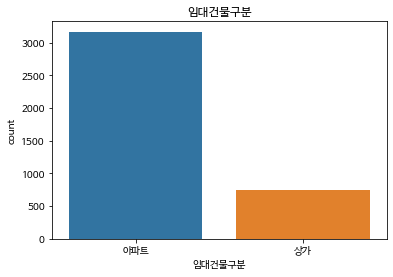

In [ ]:
sns.countplot(x="임대건물구분", data=data)
plt.title("임대건물구분")
plt.show()

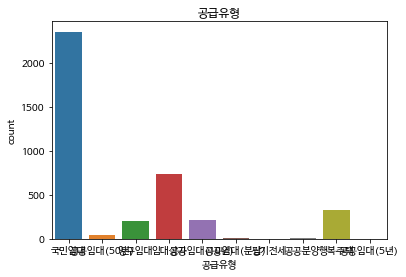

In [ ]:
sns.countplot(x="공급유형", data=data)
plt.title("공급유형")
plt.show()

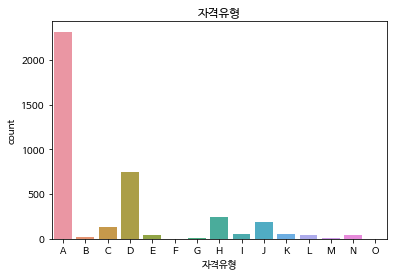

In [ ]:
sns.countplot(x="자격유형", data=data)
plt.title("자격유형")
plt.show()

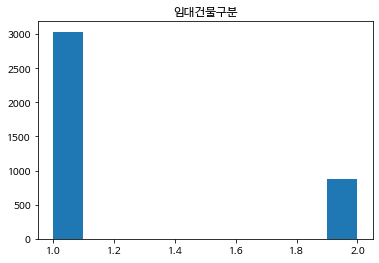

In [ ]:
code_dupli(data,'임대건물구분')

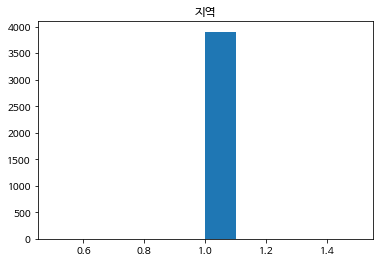

In [ ]:
code_dupli(data,'지역')

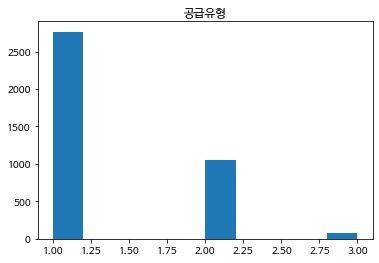

In [ ]:
code_dupli(data,'공급유형')

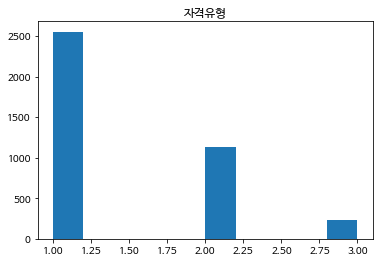

In [ ]:
code_dupli(data,'자격유형')

In [ ]:
pd.crosstab(data['공급유형'], data['자격유형'], margins=True).style.background_gradient(cmap='summer_r')

자격유형,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,All
공급유형,,,,,,,,,,,,,,,,
공공분양,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7
공공임대(10년),214,0,0,0,0,0,0,0,0,0,0,0,0,0,0,214
공공임대(50년),44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44
공공임대(5년),3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
공공임대(분납),13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
국민임대,2035,21,0,0,44,0,10,247,0,0,0,0,0,0,0,2357
영구임대,2,0,129,3,3,3,0,0,56,0,0,0,0,0,0,196
임대상가,0,0,0,739,0,0,0,0,0,0,0,0,0,0,0,739
장기전세,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


위의 그래프는 각 단지의 column별 종류의 개수를 히스토그램으로 나타낸 것이다.
임대건물구분, 공급유형, 자격유형은 하나의 단지의 여러 종류의 유형이 들어가 있음을 알 수 있다.
위에 크로스탭을 보아 자격유형 (J,K,L,M,N,O), (B,G,H), (C,F,I) 묶고
공급유형(공공임대(10년), 공공임대(50년), 공공임대(5년), 공공임대(분납), 장기전세), (임대상가, 공공분양) 이렇게 다시 범주화 한다.)


In [ ]:
data.loc[(data.자격유형=='J')|(data.자격유형=='K')|(data.자격유형=='L')|(data.자격유형=='M')|(data.자격유형=='N')|(data.자격유형=='O'),'자격유형']='JKLMNO'
data.loc[(data.자격유형=='B')|(data.자격유형=='G')|(data.자격유형=='H'),'자격유형']='BGH'
data.loc[(data.자격유형=='C')|(data.자격유형=='F')|(data.자격유형=='I'),'자격유형']='CFI'

data.loc[(data.공급유형=='공공임대(5년)')|(data.공급유형=='공공임대(10년)')|(data.공급유형=='공공임대(50년)')|(data.공급유형=='공공임대(분납)')|(data.공급유형=='장기전세'),'공급유형']='공공임대_장기전세'
data.loc[(data.공급유형=='임대상가')|(data.공급유형=='공공분양'),'공급유형']='임대상가_공공분양'

### 연속형 변수 탐색

([<matplotlib.axis.XTick at 0x7f5b353f5ed0>], [Text(0, 0, '전용면적')])

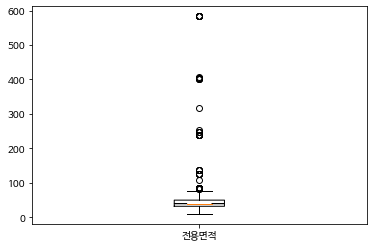

In [ ]:
plt.boxplot(data[['전용면적']].dropna().values, notch=True)
plt.xticks([1],['전용면적'])

([<matplotlib.axis.XTick at 0x7f5b353f5bd0>], [Text(0, 0, '임대보증금')])

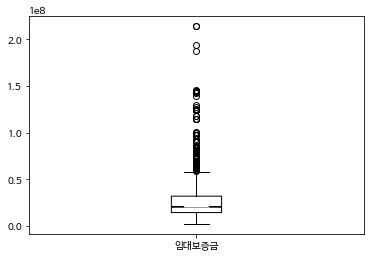

In [ ]:
plt.boxplot(data[['임대보증금']].dropna().values, notch=True)
plt.xticks([1],['임대보증금'])

([<matplotlib.axis.XTick at 0x7f5b364d6850>], [Text(0, 0, '임대료')])

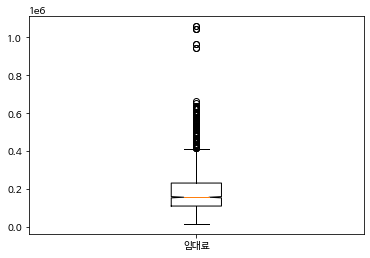

In [ ]:
plt.boxplot(data[['임대료']].dropna().values, notch=True)
plt.xticks([1],['임대료'])

In [ ]:
data[['전용면적','임대보증금','임대료','도보 10분거리 내 지하철역 수(환승노선 수 반영)','도보 10분거리 내 버스정류장 수','단지내주차면수']].describe()

,전용면적,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
count,3904.000000,3.137000e+03,3.134000e+03,3651.000000,3900.000000,3904.000000
mean,44.276217,2.570353e+07,1.879700e+05,0.169269,3.947692,582.123975
std,33.083356,1.876572e+07,1.192975e+05,0.433334,3.621108,379.840543
min,9.960000,2.249000e+06,1.665000e+04,0.000000,0.000000,13.000000
25%,32.100000,1.441800e+07,1.107900e+05,0.000000,2.000000,278.000000
50%,39.820000,2.052500e+07,1.572000e+05,0.000000,3.000000,490.000000
75%,49.960000,3.195800e+07,2.319075e+05,0.000000,4.250000,804.000000
max,583.400000,2.138630e+08,1.058030e+06,3.000000,50.000000,1798.000000


### 이상치 처리

In [ ]:
#이상치 제거 대충
data.loc[data.전용면적>200,'전용면적']=200
data.loc[data.임대보증금>150000000,'임대보증금']=150000000
data.loc[data.임대료>800000,'임대료']=800000

In [ ]:
#지하철 변수를 지하철의 유 무
#버스 정류장 개수를 1, 2, 3, 4, 5 이상으로 재범주화

data.loc[data['도보 10분거리 내 지하철역 수(환승노선 수 반영)']==0,'도보 10분거리 내 지하철역 수(환승노선 수 반영)']='무'
data.loc[data['도보 10분거리 내 지하철역 수(환승노선 수 반영)']!='무','도보 10분거리 내 지하철역 수(환승노선 수 반영)']='유'
data.loc[data['도보 10분거리 내 버스정류장 수']>=5,'도보 10분거리 내 버스정류장 수']='5 이상'

In [ ]:
# LabelEncoder를 이용하여 지역, 지하철, 버스 라벨 인코더

data['지역'] = LabelEncoder().fit_transform(data['지역'])
data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = LabelEncoder().fit_transform(data['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].astype(str))
data['도보 10분거리 내 버스정류장 수'] = LabelEncoder().fit_transform(data['도보 10분거리 내 버스정류장 수'].astype(str))

### 결측치 처리

In [ ]:
data.isnull().sum()

단지코드                               0
총세대수                               0
임대건물구분                             0
지역                                 0
공급유형                               0
전용면적                               0
전용면적별세대수                           0
공가수                                0
자격유형                               2
임대보증금                            767
임대료                              770
도보 10분거리 내 지하철역 수(환승노선 수 반영)       0
도보 10분거리 내 버스정류장 수                 0
단지내주차면수                            0
등록차량수                           1022
dtype: int64

data의 결측값을 확인했더니  임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수 변수에 결측값이 존재한다

In [ ]:
#임대보증금, 임대료 결측치 처리
data.loc[(data.자격유형!='D')&(data.임대료.isna())].단지코드.unique()

array(['C1039', 'C1326', 'C1786', 'C2186', 'C2152', 'C1267'], dtype=object)

In [ ]:
na_rent=data.loc[data.임대료.isna()]
na_security_deposit=data.loc[data.임대보증금.isna()]

In [ ]:
for i in na_rent.index:
  data.loc[i,'임대료'] = data.loc[(data.임대건물구분==na_rent.임대건물구분[i]) & (data.공급유형==na_rent.공급유형[i]) & (data.자격유형==na_rent.자격유형[i]) & (data.지역==na_rent.지역[i]) & (data.전용면적>=na_rent.전용면적[i]-5) & (data.전용면적<=na_rent.전용면적[i]+5)].임대료.mean()

for i in na_security_deposit.index:
  data.loc[i,'임대보증금']  = data.loc[(data.임대건물구분==na_security_deposit.임대건물구분[i]) & (data.공급유형==na_security_deposit.공급유형[i]) & (data.자격유형==na_security_deposit.자격유형[i]) & (data.지역==na_security_deposit.지역[i]) & (data.전용면적>=na_security_deposit.전용면적[i]-5) & (data.전용면적<=na_security_deposit.전용면적[i]+5)].임대보증금.mean()

In [ ]:
data.loc[(data.자격유형!='D')&(data.임대료.isna())].단지코드.unique()

array(['C1326', 'C1786', 'C2186'], dtype=object)

In [ ]:
data=data.loc[(data.단지코드!='C1326') & (data.단지코드!='C1786') & (data.단지코드!='C2186')]

In [ ]:
#지하철역 수, 버스정류장 수 결측치는 최빈값으로 대체한다.
data=fillna_(data, ['자격유형','도보 10분거리 내 지하철역 수(환승노선 수 반영)','도보 10분거리 내 버스정류장 수'], 'most_frequent')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### 데이터 변환

In [ ]:
df=data[['임대건물구분','공급유형','자격유형']].drop_duplicates().reset_index(drop=True)

In [ ]:
for i in range(df.shape[0]):
  data[df.임대건물구분[i]+'_'+df.공급유형[i]+"_"+df.자격유형[i]]=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(df.shape[0]):
  data.loc[(data.임대건물구분==df.임대건물구분[i])&(data.공급유형==df.공급유형[i])&(data.자격유형==df.자격유형[i]),df.임대건물구분[i]+'_'+df.공급유형[i]+"_"+df.자격유형[i]]=data.loc[(data.임대건물구분==df.임대건물구분[i])&(data.공급유형==df.공급유형[i])&(data.자격유형==df.자격유형[i]),'전용면적별세대수']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
data['총 면적']=data.전용면적*data.전용면적별세대수

In [ ]:
new_data=pd.DataFrame()
new_data=pd.concat([new_data,data.groupby('단지코드')['총 면적'].sum()],axis=1)
new_data=pd.concat([new_data,data.groupby('단지코드')['임대보증금'].sum()],axis=1)
new_data=pd.concat([new_data,data.groupby('단지코드')['임대료'].sum()],axis=1)
for i in range(df.shape[0]):
  new_data=pd.concat([new_data,data.groupby('단지코드')[df.임대건물구분[i]+'_'+df.공급유형[i]+"_"+df.자격유형[i]].sum()],axis=1)

In [ ]:
data_1=data[['단지코드','총세대수','지역','공가수','도보 10분거리 내 지하철역 수(환승노선 수 반영)','도보 10분거리 내 버스정류장 수','단지내주차면수','등록차량수']].drop_duplicates('단지코드')
data_1.index=data_1.단지코드
data_1.drop('단지코드',axis=1,inplace=True)
final_data=pd.concat([data_1,new_data],axis=1)

In [ ]:
final_data

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,총 면적,임대보증금,임대료,아파트_국민임대_A,아파트_국민임대_BGH,아파트_공공임대_장기전세_A,아파트_영구임대_CFI,상가_임대상가_공공분양_D,아파트_영구임대_E,아파트_국민임대_E,아파트_임대상가_공공분양_D,아파트_영구임대_A,아파트_행복주택_JKLMNO,아파트_영구임대_D
C2515,545,2,17.0,0,3,624.0,205.0,21941.82,1.175100e+08,9.769000e+05,545,0,0,0,0,0,0,0,0,0,0
C1407,1216,6,13.0,1,1,1285.0,1064.0,49159.08,3.136160e+08,1.944030e+06,1216,0,0,0,0,0,0,0,0,0,0
C1945,755,1,6.0,1,3,734.0,730.0,37962.15,1.359100e+08,1.134640e+06,0,755,0,0,0,0,0,0,0,0,0
C1470,696,12,14.0,0,2,645.0,553.0,31250.88,7.089100e+07,4.806000e+05,696,0,0,0,0,0,0,0,0,0,0
C1898,566,12,9.0,0,5,517.0,415.0,24174.04,1.045340e+08,7.148900e+05,566,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2456,346,13,17.0,0,4,270.0,NaN,12654.70,4.891500e+07,6.203300e+05,0,346,0,0,0,0,0,0,0,0,0
C1266,591,15,35.0,0,1,593.0,NaN,21191.31,7.177600e+07,9.993900e+05,0,591,0,0,0,0,0,0,0,0,0
C2152,120,0,9.0,0,1,40.0,NaN,3466.14,1.230611e+07,1.811275e+05,0,0,0,120,0,0,0,0,0,0,0
C1267,670,2,38.0,0,1,467.0,NaN,21636.46,2.525879e+08,1.209023e+06,0,310,0,110,0,0,0,0,0,250,0


### final_data 탐색

In [ ]:
final_data.describe()

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,총 면적,임대보증금,임대료,아파트_국민임대_A,아파트_국민임대_BGH,아파트_공공임대_장기전세_A,아파트_영구임대_CFI,상가_임대상가_공공분양_D,아파트_영구임대_E,아파트_국민임대_E,아파트_임대상가_공공분양_D,아파트_영구임대_A,아파트_행복주택_JKLMNO,아파트_영구임대_D
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,410.000000,560.000000,5.600000e+02,5.600000e+02,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,707.983929,5.633929,13.844643,0.142857,3.155357,575.557143,566.307317,30586.554643,1.437737e+08,1.051844e+06,431.273214,67.276786,66.819643,80.462500,1.319643,0.967857,11.580357,1.269643,1.551786,44.091071,0.046429
std,403.024302,5.069103,10.465847,0.350240,1.359709,348.498482,388.880266,17308.720255,1.314817e+08,8.998099e+05,397.972660,250.477234,215.388490,302.842813,5.532435,19.219820,74.908321,30.045234,31.905846,197.574290,1.098701
min,26.000000,0.000000,0.000000,0.000000,0.000000,13.000000,13.000000,711.140000,3.056000e+06,6.800000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,420.000000,1.000000,5.000000,0.000000,2.000000,316.750000,285.000000,18207.777500,6.223275e+07,5.217675e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,619.500000,4.000000,13.000000,0.000000,3.000000,512.000000,505.000000,27271.485000,1.040485e+08,7.707150e+05,406.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,919.750000,11.000000,21.000000,0.000000,4.000000,773.500000,756.250000,39581.070000,1.845315e+08,1.312485e+06,690.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2572.000000,15.000000,55.000000,1.000000,6.000000,1798.000000,2550.000000,94979.630000,1.037727e+09,8.560000e+06,1722.000000,2334.000000,1444.000000,2529.000000,45.000000,450.000000,798.000000,711.000000,745.000000,2200.000000,26.000000


In [ ]:
# 공가율 파생변수 생성
final_data['공가율']=final_data.공가수/final_data.총세대수

In [ ]:
discrete_variables=['지역','도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수']
continuous_variable=['등록차량수','총세대수', '공가수', '단지내주차면수','총 면적', '임대보증금', '임대료', '공가율']

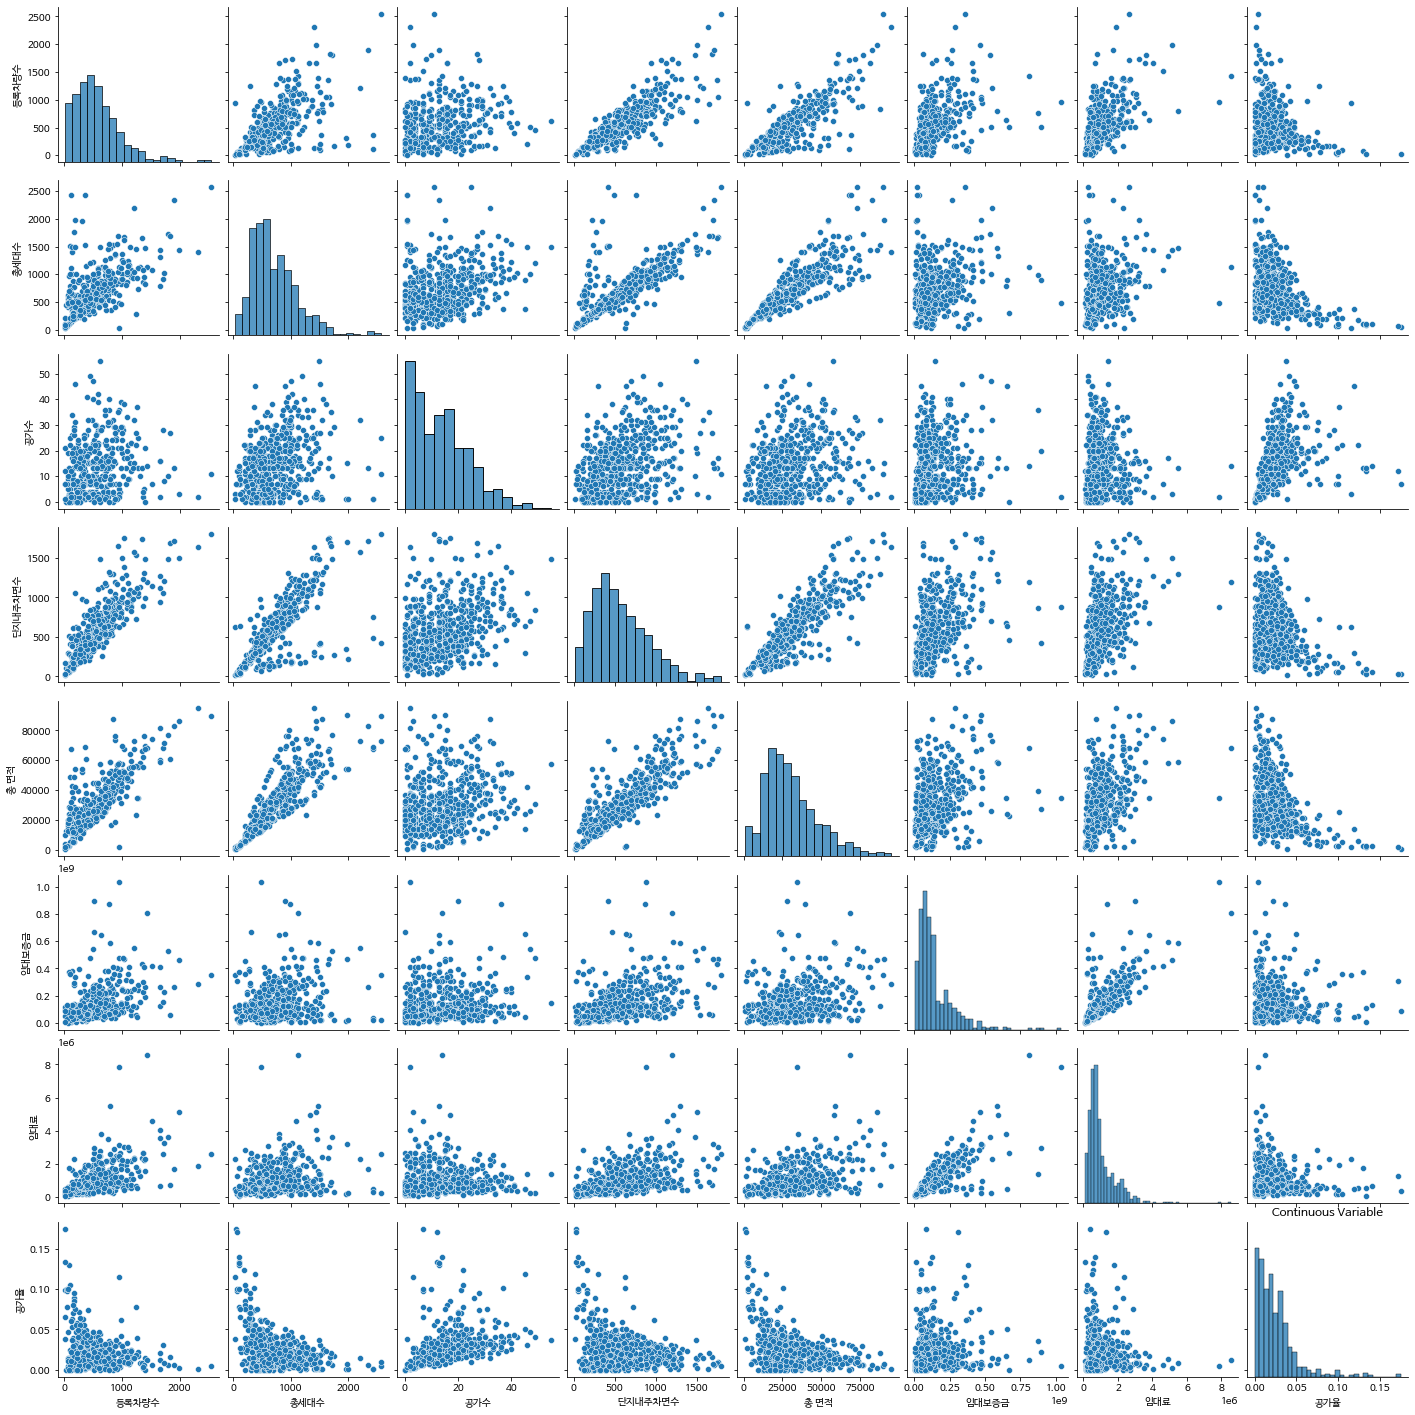

In [ ]:
sns.pairplot(final_data.loc[:,continuous_variable])
plt.title("Continuous Variable")
plt.show()

In [ ]:
#TrainSet과 Test으로 구분
new_train=pd.DataFrame()
new_test=pd.DataFrame()

for code in list(train.단지코드.unique()):
  new_train=new_train.append(final_data.loc[final_data.index==code])

for code in list(test.단지코드.unique()):
  new_test=new_test.append(final_data.loc[final_data.index==code])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


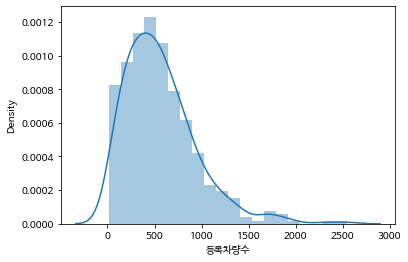

In [ ]:
sns.distplot(new_train['등록차량수'])

## 3. 모델링

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
s_scaler=StandardScaler()
train_y=new_train['등록차량수']
train_X=new_train.drop('등록차량수',axis=1)
test_X=new_test.drop('등록차량수',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.1, random_state=12)

회귀모델

In [ ]:
def cv_rmse(model,x,y):
    rmse = np.sqrt(-cross_val_score(model, s_scaler.fit_transform(x) , y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = 5))
    return(rmse)

def ridge_selector(k,x,y):
    ridge_model = make_pipeline(RidgeCV(alphas = [k],
                                        cv=5)).fit(s_scaler.fit_transform(x), y)
    ridge_rmse = cv_rmse(ridge_model,x,y).mean()
    return(ridge_rmse)

,RMSE
4.80,182.604539
4.85,182.604194
4.90,182.603982
4.95,182.603900
5.00,182.603944
5.05,182.604112
5.10,182.604400


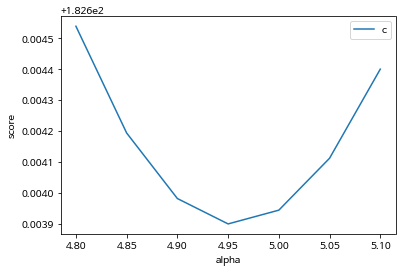

In [ ]:
r_alphas = [4.8,4.85,4.9,4.95,5,5.05,5.1]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha, X_train, y_train)
    ridge_scores.append(score)
    
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [ ]:
RIDGE=Ridge(alpha=4.95,random_state=12)
RIDGE.fit(s_scaler.fit_transform(X_train),y_train)
pred_RIDGE=RIDGE.predict(s_scaler.fit_transform(X_test))

부스팅,  붓스트랩 트리

In [ ]:
from sklearn.linear_model import  Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
# 데이터를 로딩하고 학습데이타와 테스트 데이터 분리

XGB = XGBRegressor()
RF = RandomForestRegressor()

XGB_param = {
    'learning_rate':[0.1,0.2], 
    'n_estimators':[100,150,200],
    'max_depth':[2,4,6,8], 
    'subsample':[0.5,0.7,0.9], 
    'colsample_bytree':[0.5,0.7,0.9],
    'min_samples_split':[2,3]
    }
RF_param = {
    'n_estimators':[100,150,200],
    'max_depth':[2,4,6,8], 
    'min_samples_leaf':[2,3],
    'min_samples_split':[2,3,4]
    }

In [ ]:
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_XGB = GridSearchCV(XGB, param_grid=XGB_param, cv=5, refit=True, return_train_score=True,
                        scoring='neg_mean_squared_error')
grid_XGB.fit(X_train, y_train)

grid_RF = GridSearchCV(RF, param_grid=RF_param, cv=5, refit=True, return_train_score=True,
                       scoring='neg_mean_squared_error')
grid_RF.fit(X_train, y_train)

# GridSearchCV 결과는 cv_results_ 라는 딕셔너리로 저장됨. 이를 DataFrame으로 변환
scores_df_XGB = pd.DataFrame(grid_XGB.cv_results_)
scores_df_RF = pd.DataFrame(grid_RF.cv_results_)

In [ ]:
scores_df_XGB.mean_test_score=np.sqrt(-scores_df_XGB.mean_test_score)
scores_df_XGB.std_train_score=np.sqrt(scores_df_XGB.std_train_score)
scores_df_XGB.split0_test_score=np.sqrt(-scores_df_XGB.split0_test_score)
scores_df_XGB.split1_test_score=np.sqrt(-scores_df_XGB.split1_test_score)
scores_df_XGB.split2_test_score=np.sqrt(-scores_df_XGB.split2_test_score)
scores_df_XGB.split3_test_score=np.sqrt(-scores_df_XGB.split3_test_score)
scores_df_XGB.split4_test_score=np.sqrt(-scores_df_XGB.split4_test_score)

scores_df_RF.mean_test_score=np.sqrt(-scores_df_RF.mean_test_score)
scores_df_RF.std_train_score=np.sqrt(scores_df_RF.std_train_score)
scores_df_RF.split0_test_score=np.sqrt(-scores_df_RF.split0_test_score)
scores_df_RF.split1_test_score=np.sqrt(-scores_df_RF.split1_test_score)
scores_df_RF.split2_test_score=np.sqrt(-scores_df_RF.split2_test_score)
scores_df_RF.split3_test_score=np.sqrt(-scores_df_RF.split3_test_score)
scores_df_RF.split4_test_score=np.sqrt(-scores_df_RF.split4_test_score)

In [ ]:
scores_df_XGB[['rank_test_score','params', 'mean_test_score','std_train_score',  
           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values('rank_test_score').head(5)

,rank_test_score,params,mean_test_score,std_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
289,1,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",194.444645,15.427918,195.077831,194.651648,169.835584,207.111684,203.370600
298,1,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",194.444645,15.427918,195.077831,194.651648,169.835584,207.111684,203.370600
304,3,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",195.339740,18.930358,198.207641,196.705159,167.280758,207.131032,204.750495
295,3,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",195.339740,18.930358,198.207641,196.705159,167.280758,207.131032,204.750495
292,5,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",195.891849,19.189187,198.674076,194.975916,167.632427,207.965433,207.438746


In [ ]:
scores_df_RF[['rank_test_score','params', 'mean_test_score','std_train_score',  
           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values('rank_test_score').head(5)

,rank_test_score,params,mean_test_score,std_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
62,1,"{'max_depth': 8, 'min_samples_leaf': 2, 'min_s...",197.660758,24.067901,184.271782,216.183980,178.044176,214.225915,192.522212
44,2,"{'max_depth': 6, 'min_samples_leaf': 2, 'min_s...",198.266168,20.798448,188.215324,211.943622,181.268349,215.667008,191.916092
38,3,"{'max_depth': 6, 'min_samples_leaf': 2, 'min_s...",198.952667,19.316410,183.559045,218.173595,182.444971,214.840380,192.807216
55,4,"{'max_depth': 8, 'min_samples_leaf': 2, 'min_s...",199.117951,24.546255,185.451063,217.226329,177.956940,217.898109,193.680559
60,5,"{'max_depth': 8, 'min_samples_leaf': 2, 'min_s...",199.172112,22.694906,182.327208,215.607289,188.745992,211.737916,195.345700


In [ ]:
print('XGB GridSearchCV 최적 파라미터:', grid_XGB.best_params_)
print('XGB GridSearchCV 최고 정확도: {0:.4f}'.format(np.sqrt(-grid_XGB.best_score_)))

print('RF GridSearchCV 최적 파라미터:', grid_RF.best_params_)
print('RF GridSearchCV 최고 정확도: {0:.4f}'.format(np.sqrt(-grid_RF.best_score_)))


# refit=True로 설정된 GridSearchCV 객체가 fit()을 수행 시 학습이 완료된 Estimator를 내포하고 있으므로 predict()를 통해 예측도 가능. 
pred_XGB = grid_XGB.predict(X_test)
pred_RF = grid_RF.predict(X_test)

print('XGB : 테스트 데이터 세트 정확도: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test,pred_XGB))))
print('RF : 테스트 데이터 세트 정확도: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test,pred_RF))))
print('RIDGE : 테스트 데이터 세트 정확도: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test,pred_RIDGE))))

XGB GridSearchCV 최적 파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.7}
XGB GridSearchCV 최고 정확도: 194.4446
RF GridSearchCV 최적 파라미터: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
RF GridSearchCV 최고 정확도: 197.6608
XGB : 테스트 데이터 세트 정확도: 152.3748
RF : 테스트 데이터 세트 정확도: 149.9082
RIDGE : 테스트 데이터 세트 정확도: 154.9575


In [ ]:
votingC = VotingRegressor(estimators=[('XGB',grid_XGB.best_estimator_),('RF',grid_RF.best_estimator_) ,('Ridge', RIDGE)], n_jobs=-1)
votingC = votingC.fit(s_scaler.fit_transform(X_train),y_train)
pred_voting=votingC.predict(s_scaler.fit_transform(X_test))

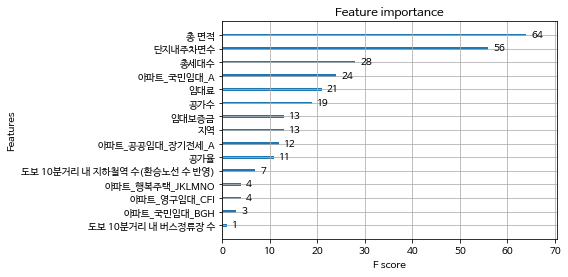

In [ ]:
plot_importance(grid_XGB.best_estimator_)

In [ ]:
print('Voting : 테스트 데이터 세트 정확도: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test,pred_voting))))

Voting : 테스트 데이터 세트 정확도: 150.2447
